# Inspect GLASS models and generate synthetic images

## Imports

In [1]:
import sys
import os
import numpy as np
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
root = "/Users/phdenzel/gleam"
sys.path.append(root)
import gleam
from gleam.lensobject import LensObject
from gleam.utils.lensing import LensModel
from gleam.reconsrc import ReconSrc, run_model
from gleam.utils.plotting import kappa_map_plot, kappa_profiles_plot
from gleam.utils.plotting import arrival_time_surface_plot
from gleam.utils.plotting import plot_scalebar, plot_labelbox
from gleam.utils.rgb_map import radial_mask
from gleam.utils.units import H02aHz, aHz2H0, H02Gyrs, H02critdens
import gleam.utils.colors as gcl
gcl.GLEAMcmaps.register_all()


## Load data files

In [2]:
#        ACS          ACS(WFC3)        ACS(WFC3)      WFC3(UNK)
#        ACS(WFC3)    SBC              WFC3           ACS(GAIA)
objs = ['B1608+656', 'DESJ0408-5354', 'HE0435-1223', 'PG1115+080',
        'RXJ0911+0551', 'RXJ1131-1231', 'SDSSJ1004+4112', 'WFIJ2033-4723']
objidx = 3
sigf = 600     #   80,  100,   60,  600,  140, 4000,   80,   80
lens = objs[objidx]
print(lens)


PG1115+080


In [3]:
fitsdir = 'data/delay_qsos/'
fitsfile = fitsdir + '{}.fits'.format(lens)
print(fitsfile)

jsondir = 'jsons/'
jsonfile = jsondir + '{}.json'.format(lens)
print(jsonfile)


data/delay_qsos/PG1115+080.fits
jsons/PG1115+080.json


In [4]:
with open(jsonfile) as f:
    lo = LensObject.from_json(f)
lo.squarify(0)
print(lo.__v__)


Properties of that field are unknown [None]
filename            	PG1115+080.json
filepath            	/Users/phdenzel/delays/jsons/PG1115+080.json
band                	
naxis1              	99
naxis2              	99
naxis_plus          	None
refval              	[169.57094740092, 7.766067434866]
refpx               	[36.0, 41.0]
center              	<169.5705, 7.7664>
px2deg              	[3.562500079472802e-05, 3.5625000794728505e-05]
px2arcsec           	[0.12825000286102087, 0.12825000286102262]
megacam_range       	None
field               	None
photzp              	None
mag_formula         	<function mag_formula at 0x7f8717ba4e60>
roi                 	ROISelector(99, 99)
lens                	None
srcimgs             	[]
zl                  	0.5
zs                  	3.0
mapr                	6.3484
tdelay              	None
tderr               	None
light_model         	{}
stel_mass           	None
glscfactory         	GLSCFactory(zl, srcimgs, parity, tderr...)
finder              

In [5]:
statedir = 'states/'
statefiles = ['11doubles_dg45.state',
              '11doubles_dg60.state', '11doubles_CMB_dg60.state', '11doubles_SNeIa_dg60.state',
              '7quads_dg45.state', '7quads_CMB_dg45.state', '7quads_SNeIa_dg45.state',
              '7quads_dg60.state', '7quads_CMB_dg60.state', '7quads_SNeIa_dg60.state', 
              'all_dg60.state', 'all_SNeIa_dg60.state']
statefile = statefiles[7]  # 7  8/9 5/6
print(statefile)


7quads_dg60.state


In [6]:
lm = LensModel(statedir+statefile)
lm.obj_idx = objidx
print(lm.__v__)


filename            	7quads_dg60.state
filepath            	states/7quads_dg60.state
N                   	1000
pixrad              	8
maprad              	1.67273244599
pixel_size          	0.0393584104938
kappa               	None
minima              	[[ 0.11439883300091856  1.3727859960110342 ]
 [-0.7864919768813123  -0.872291101632015  ]]
saddle_points       	[[-1.058189205258495   -0.4289956237534523 ]
 [ 0.8579912475068856  -0.45759533200368047]]
maxima              	[]
zl                  	0.311
zs                  	1.735
N_obj               	8
N_src               	1
obj_idx             	3
src_idx             	0


## Hubble constant

In [7]:
hoaHz = H02aHz(70.0)
print(hoaHz)
print(H02aHz(1.0))

aHzH0 = H02aHz(lm.H0)
invH0 = H02Gyrs(lm.H0)
rhocrit = H02critdens(lm.H0)


2.2685455026110537
0.03240779289444362


In [8]:
def lorentzian(x, mu, gamma, I):
    return I/(np.pi*gamma) * gamma*gamma/((x - mu)**2 + gamma*gamma)

def gaussian(x, mu, sigma, I):
    return I/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*(mu - x)**2/(2*sigma**2))

# xi = np.linspace(-10, 30, 300)
# plt.plot(xi, lorentzian(xi, 10, 10, 10*np.pi))
# plt.show()

In [9]:
%%script false
q = np.percentile(aHzH0, [16, 50, 84])
dist, bin_edges = np.histogram(aHzH0, bins=50, density=True)
# dist *= np.diff(bin_edges)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

popt, pcov = curve_fit(lorentzian, bin_centers, dist)
print(popt)

plt.plot(bin_centers, dist)
plt.plot(bin_centers, lorentzian(bin_centers, popt[0], popt[1], popt[2]))
plt.show()


In [10]:
class Measure(object):
    def __init__(self, name, mean, std=None):
        self.name = name
        self.mean = mean
        if isinstance(std, (int, float)):
            std = (-std, std)
        self.std = std
        
    def __call__(self, y=0):
        measure = [self.sig_lims[0], self.mean, self.sig_lims[1]]
        return measure, [y for i in measure]
    
    def plot(self, y=0, color=None, msize=4, xshift=0, yshift=0, lw=3, fontsize=18):
        estimate = self(y)
        plt.scatter(self.mean, y, s=msize, color=color)
        plt.plot(*estimate, lw=lw, color=color)
        plt.text(self.mean+xshift, y+yshift, self.name, color='black',
                 fontsize=fontsize, horizontalalignment='center')

    @property
    def sig_lims(self):
        return self.mean+self.std[0], self.mean+self.std[1]

planck = Measure(name="Planck", mean=67.4, std=0.5)  # arxiv.org/abs/1807.06209
shoes = Measure(name="SH0ES", mean=74.03, std=1.42)  # arxiv.org/abs/1903.07603
cchp = Measure(name="CCHP", mean=69.8, std=1.7)  # arxiv.org/abs/1907.05922
print(planck())

([66.9, 67.4, 67.9], [0, 0, 0])


(1.7106349455667007, 0.6964244345133984, 1.0887475543451728)


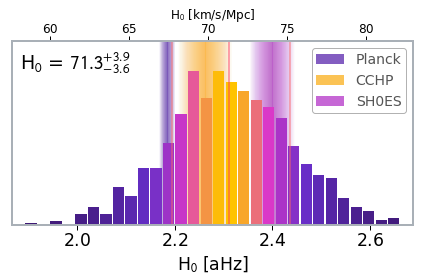

In [11]:
#%%script false
q = np.percentile(aHzH0, [16, 50, 84])

fig, ax = plt.subplots()
axc = ax.twiny()
# second unit axis
def convertaxc(ax):
    x1, x2 = ax.get_xlim()
    axc.set_xlim(aHz2H0(x1), aHz2H0(x2))
    axc.figure.canvas.draw()
ax.callbacks.connect("xlim_changed", convertaxc)

n, bins, patches = ax.hist(aHzH0, bins=30, density=True, rwidth=0.901)
cm = plt.cm.get_cmap('phoenix')
ax.axvline(q[1], color=gcl.pink, alpha=0.6)
ax.axvline(q[0], color=gcl.red, alpha=0.6)
ax.axvline(q[2], color=gcl.red, alpha=0.6)
yl = ax.get_ylim()

# add gaussian/lorentzian/voigt color scheme to pdf
bin_centers = 0.5 * (bins[:-1] + bins[1:])
def lorentzian(x, mu, gamma, I):
    return I/(np.pi*gamma) * gamma*gamma/((x - mu)**2 + gamma*gamma)
def gaussian(x, mu, sigma, I):
    return I/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*(mu - x)**2/sigma**2)
def pseudovoigt(x, x0, sigma, gamma, eta, I):
    g = np.exp(0.5*(x-x0)**2/(sigma**2))
    l = gamma*gamma / ((x-x0)**2 + gamma*gamma)
    return I*(eta*g + (1-eta)*l)
dx = bin_centers[1]-bin_centers[0]
xdata = [bin_centers[0]-i*dx for i in range(1, 16)] + list(bin_centers) + [bin_centers[-1]+i*dx for i in range(1, 16)]
ydata = [0 for i in range(15)] + list(n) + [0 for i in range(15)]
lpopt, lpcov = curve_fit(lorentzian, xdata, ydata)
ldist = lorentzian(bin_centers, lpopt[0], lpopt[1], lpopt[2])
gpopt, gpcov = curve_fit(gaussian, xdata, ydata)
gdist = gaussian(bin_centers, gpopt[0], gpopt[1], gpopt[2])
vpopt, vpcov = curve_fit(pseudovoigt, xdata, ydata)
vdist = pseudovoigt(bin_centers, vpopt[0], vpopt[1], vpopt[2], vpopt[3], vpopt[4])
for c, p in zip(ldist/ldist.max(), patches):
    plt.setp(p, 'facecolor', cm(c))

# # add gaussian/lorentzian/voigt fits
# xdata = np.linspace(xdata[0], xdata[-1], 200)
# lfit = lorentzian(xdata, lpopt[0], lpopt[1], lpopt[2])
# ax.plot(xdata, lfit, label='Lorentzian', color=cm(0.5))
# gfit = gaussian(xdata, gpopt[0], gpopt[1], gpopt[2])
# ax.plot(xdata, gfit, label='Gaussian', color=cm(0.1))
# vfit = pseudovoigt(xdata, vpopt[0], vpopt[1], vpopt[2], vpopt[3], vpopt[4])
# ax.plot(xdata, vfit, label='Pseudo-Voigt', color=cm(1.0))
# ax.legend(loc='upper right', fontsize=10, numpoints=1, borderpad=0.3)

lchi2 = np.sum((ldist - n)**2)/np.sqrt(2)
gchi2 = np.sum((gdist - n)**2)/np.sqrt(2)
vchi2 = np.sum((vdist - n)**2)/np.sqrt(2)
# lchi2 = np.sum((ldist - n)**2)
# gchi2 = np.sum((gdist - n)**2)
# vchi2 = np.sum((vdist - n)**2)
print(lchi2, gchi2, vchi2)

# # plot the other estimates
# xmeasure = [planck, cchp, shoes]
# ymeasure = [4, 3.9, 3.8]
# for x, y, c in zip(xmeasure, ymeasure, [cm(0.25), cm(1.), cm(.5)]):
#     if x.name == 'Planck':
#         xshift = -2
#     else:
#         xshift = 0
#     x.plot(y, xshift=xshift, yshift=0.4, msize=75, color=c)
# or as axvspans
ax.axvline(H02aHz(planck.mean), color=cm(0.25), alpha=0.5, lw=0.5, zorder=0)#, label=planck.name)
ax.axvline(H02aHz(cchp.mean), color=cm(0.95), alpha=0.5, lw=0.5, zorder=0)#, label=shoes.name)
ax.axvline(H02aHz(shoes.mean), color=cm(0.55), alpha=0.5, lw=0.5, zorder=0)#, label=shoes.name)
plancklims = np.array(H02aHz(planck.sig_lims))
cchplims = np.array(H02aHz(cchp.sig_lims))
shoeslims = np.array(H02aHz(shoes.sig_lims))
for i in range(50):
    pstep = np.diff(plancklims)*i/100.
    cstep = np.diff(cchplims)*i/100.
    sstep = np.diff(shoeslims)*i/100.
    plims = plancklims[0] + pstep, plancklims[1] - pstep
    clims = cchplims[0] + cstep, cchplims[1] - cstep
    slims = shoeslims[0] + sstep, shoeslims[1] - sstep
    ax.axvspan(*plims, color=cm(0.25), alpha=0.02, zorder=0, lw=0)
    ax.axvspan(*clims, color=cm(0.95), alpha=0.02, zorder=0, lw=0)
    ax.axvspan(*slims, color=cm(0.55), alpha=0.02, zorder=0, lw=0)
ax.axvspan(-1, -0.99, color=cm(0.25), label=planck.name, alpha=0.75, zorder=0, lw=0)
ax.axvspan(-1, -0.99, color=cm(0.95), label=cchp.name, alpha=0.75, zorder=0, lw=0)
ax.axvspan(-1, -0.99, color=cm(0.55), label=shoes.name, alpha=0.75, zorder=0, lw=0)
ax.legend(loc='upper right', fontsize=14, numpoints=1, borderpad=0.3)

# add result text
plt.rcParams['mathtext.fontset'] = 'stixsans'
Hstr = 'H$_0$ = ${:5.1f}^{{{:+4.1f}}}_{{{:+4.1f}}}$'
q = np.percentile(lm.H0, [16, 50, 84])
plt.text(0.02, 0.85, Hstr.format(q[1], np.diff(q)[1], -np.diff(q)[0]), fontsize=19, color='black', transform=plt.gca().transAxes)

fig.axes[0].get_yaxis().set_visible(False)
ax.set_xlim(bins[0]-dx, bins[-1]+dx)
# ax.set_ylim(0, 5)
ax.set_ylim(0, 4)
# ax.set_ylim(yl)
ax.set_xlabel('H$_0$ [aHz]')
axc.set_xlabel('H$_0$ [km/s/Mpc]', fontsize=12)
plt.setp(axc.get_xticklabels(), fontsize=12)
plt.tight_layout()
plt.savefig('results/_H0hist_{}.pdf'.format(statefile.replace('.state', '')), transparent=True, bbox_inches='tight', pad_inches=0)
# plt.close()
plt.show()


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


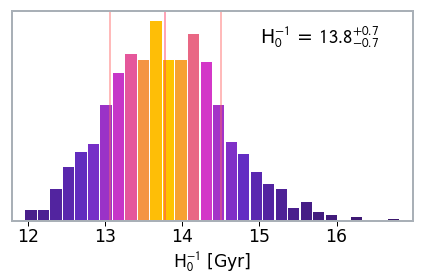

In [12]:
#%%script false
q = np.percentile(invH0, [16, 50, 84])
n, bins, patches = plt.hist(invH0, bins=30, density=True, rwidth=0.901)
cm = plt.cm.get_cmap('phoenix')
plt.axvline(q[1], color=gcl.pink, alpha=0.6)
plt.axvline(q[0], color=gcl.red, alpha=0.6)
plt.axvline(q[2], color=gcl.red, alpha=0.6)
yl = plt.gca().get_ylim()

# # add measures
# plt.axvline(H02Gyrs(planck.mean), color=cm(0.25), alpha=0.5, lw=0.2, zorder=0)#, label=planck.name)
# plt.axvline(H02Gyrs(shoes.mean), color=cm(0.55), alpha=0.5, lw=0.2, zorder=0)#, label=shoes.name)
# plancklims = np.array(H02Gyrs(planck.sig_lims))
# shoeslims = np.array(H02Gyrs(shoes.sig_lims))
# for i in range(50):
#     pstep = np.diff(plancklims)*i/100.
#     sstep = np.diff(shoeslims)*i/100.
#     plims = plancklims[0] + pstep, plancklims[1] - pstep
#     slims = shoeslims[0] + sstep, shoeslims[1] - sstep
#     plt.axvspan(*plims, color=cm(0.25), alpha=0.02, zorder=0, lw=0)
#     plt.axvspan(*slims, color=cm(0.55), alpha=0.02, zorder=0, lw=0)
# plt.axvspan(-1, -0.99, color=cm(0.25), label=planck.name, alpha=0.75, zorder=0, lw=0)
# plt.axvspan(-1, -0.99, color=cm(0.55), label=shoes.name, alpha=0.75, zorder=0, lw=0)
# plt.legend(loc=(0.7, 0.55), fontsize=14, numpoints=1, borderpad=0.3)

# add gaussian/lorentzian.voigt fits
bin_centers = 0.5 * (bins[:-1] + bins[1:])
def lorentzian(x, mu, gamma, I):
    return I/(np.pi*gamma) * gamma*gamma/((x - mu)**2 + gamma*gamma)
def gaussian(x, mu, sigma, I):
    return 1.*I/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*(mu - x)**2/sigma**2)
def pseudovoigt(x, x0, sigma, gamma, eta, I):
    g = np.exp(0.5*(x-x0)**2/(sigma**2))
    l = gamma*gamma / ((x-x0)**2 + gamma*gamma)
    return I*(eta*g + (1-eta)*l)
dx = bin_centers[1]-bin_centers[0]
xdata = [bin_centers[0]-i*dx for i in range(1, 16)] + list(bin_centers) + [bin_centers[-1]+i*dx for i in range(1, 16)]
ydata = [0 for i in range(15)] + list(n) + [0 for i in range(15)]
lpopt, lpcov = curve_fit(lorentzian, xdata, ydata)
ldist = lorentzian(bin_centers, lpopt[0], lpopt[1], lpopt[2])
gpopt, gpcov = curve_fit(gaussian, xdata, ydata)
gdist = gaussian(bin_centers, gpopt[0], gpopt[1], gpopt[2])
vpopt, vpcov = curve_fit(pseudovoigt, xdata, ydata)
vdist = pseudovoigt(bin_centers, vpopt[0], vpopt[1], vpopt[2], vpopt[3], vpopt[4])
for c, p in zip(ldist/ldist.max(), patches):
    plt.setp(p, 'facecolor', cm(c))

# # add gaussian/lorentzian/voigt fits
# xdata = np.linspace(xdata[0], xdata[-1], 200)
# fit = lorentzian(xdata, lpopt[0], lpopt[1], lpopt[2])
# plt.plot(xdata, fit, color='black')
# fit = gaussian(xdata, gpopt[0], gpopt[1], gpopt[2])
# plt.plot(xdata, fit, color='black')
# vfit = pseudovoigt(xdata, vpopt[0], vpopt[1], vpopt[2], vpopt[3], vpopt[4])
# plt.plot(xdata, vfit, color='black')

# add text
plt.rcParams['mathtext.fontset'] = 'stixsans'
Hstr = 'H$_0^{{-1}}$ = ${:5.1f}^{{{:+4.1f}}}_{{{:+4.1f}}}$'
plt.text(0.62, 0.85, Hstr.format(q[1], np.diff(q)[1], -np.diff(q)[0]), fontsize=19, color='black', transform=plt.gca().transAxes)

plt.gcf().axes[0].get_yaxis().set_visible(False)
plt.gca().set_xlim(bins[0]-dx, bins[-1]+dx)
plt.gca().set_ylim(yl)
plt.xlabel('H$_0^{-1}$ [Gyr]')
plt.tight_layout()
plt.savefig('results/_invH0hist_{}.pdf'.format(statefile.replace('.state', '')), transparent=True, bbox_inches='tight', pad_inches=0)
# plt.close()
plt.show()


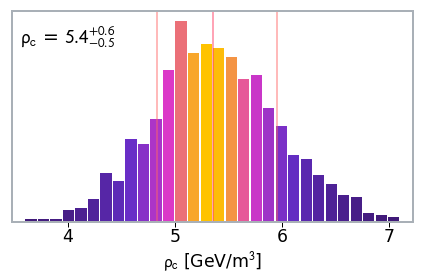

In [13]:
#%%script false
q = np.percentile(rhocrit, [16, 50, 84])
n, bins, patches = plt.hist(rhocrit, bins=30, density=True, rwidth=0.901)
cm = plt.cm.get_cmap('phoenix')
plt.axvline(q[1], color=gcl.pink, alpha=0.6)
plt.axvline(q[0], color=gcl.red, alpha=0.6)
plt.axvline(q[2], color=gcl.red, alpha=0.6)
yl = plt.gca().get_ylim()

# add measures
# plt.axvline(H02critdens(planck.mean), color=cm(0.25), alpha=0.5, lw=0.2, zorder=0)#, label=planck.name)
# plt.axvline(H02critdens(shoes.mean), color=cm(0.55), alpha=0.5, lw=0.2, zorder=0)#, label=shoes.name)
# plancklims = np.array(H02critdens(planck.sig_lims))
# shoeslims = np.array(H02critdens(shoes.sig_lims))
# for i in range(50):
#     pstep = np.diff(plancklims)*i/100.
#     sstep = np.diff(shoeslims)*i/100.
#     plims = plancklims[0] + pstep, plancklims[1] - pstep
#     slims = shoeslims[0] + sstep, shoeslims[1] - sstep
#     plt.axvspan(*plims, color=cm(0.25), alpha=0.02, zorder=0, lw=0)
#     plt.axvspan(*slims, color=cm(0.55), alpha=0.02, zorder=0, lw=0)
# plt.axvspan(-1, -0.99, color=cm(0.25), label=planck.name, alpha=0.75, zorder=0, lw=0)
# plt.axvspan(-1, -0.99, color=cm(0.55), label=shoes.name, alpha=0.75, zorder=0, lw=0)
# plt.legend(loc='upper right', fontsize=14, numpoints=1, borderpad=0.3)

# add gaussian/lorentzian/voigt color scheme to pdf
bin_centers = 0.5 * (bins[:-1] + bins[1:])
def lorentzian(x, mu, gamma, I):
    return I/(np.pi*gamma) * gamma*gamma/((x - mu)**2 + gamma*gamma)
def gaussian(x, mu, sigma, I):
    return I/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*(mu - x)**2/sigma**2)
def pseudovoigt(x, x0, sigma, gamma, eta, I):
    g = np.exp(0.5*(x-x0)**2/sigma**2)
    l = gamma*gamma / ((x-x0)**2 + gamma*gamma)
    return I*(eta*g + (1-eta)*l)
dx = bin_centers[1]-bin_centers[0]
xdata = [bin_centers[0]-i*dx for i in range(1, 16)] + list(bin_centers) + [bin_centers[-1]+i*dx for i in range(1, 16)]
ydata = [0 for i in range(15)] + list(n) + [0 for i in range(15)]
lpopt, lpcov = curve_fit(lorentzian, xdata, ydata)
ldist = lorentzian(bin_centers, lpopt[0], lpopt[1], lpopt[2])
gpopt, gpcov = curve_fit(gaussian, xdata, ydata)
gdist = gaussian(bin_centers, gpopt[0], gpopt[1], gpopt[2])
vpopt, vpcov = curve_fit(pseudovoigt, xdata, ydata)
vdist = pseudovoigt(bin_centers, vpopt[0], vpopt[1], vpopt[2], vpopt[3], vpopt[4])
for c, p in zip(ldist/ldist.max(), patches):
    plt.setp(p, 'facecolor', cm(c))

# # add gaussian/lorentzian/voigt fits
# xdata = np.linspace(xdata[0], xdata[-1], 200)
# lfit = lorentzian(xdata, lpopt[0], lpopt[1], lpopt[2])
# plt.plot(xdata, lfit, color='black')
# gfit = gaussian(xdata, gpopt[0], gpopt[1], gpopt[2])
# plt.plot(xdata, gfit, color='black')
# vfit = pseudovoigt(xdata, vpopt[0], vpopt[1], vpopt[2], vpopt[3], vpopt[4])
# plt.plot(xdata, vfit, color='black')

# add text
plt.rcParams['mathtext.fontset'] = 'stixsans'
Hstr = r"$\rho_{{\mathrm{{c}}}}$ = ${:5.1f}^{{{:+4.1f}}}_{{{:+4.1f}}}$"
plt.text(0.02, 0.85, Hstr.format(q[1], np.diff(q)[1], -np.diff(q)[0]), fontsize=19, color='black', transform=plt.gca().transAxes)

plt.gcf().axes[0].get_yaxis().set_visible(False)
plt.gca().set_xlim(bins[0]-dx, bins[-1]+dx)
# plt.gca().set_ylim(yl)
plt.xlabel(r"$\rho_{\mathrm{c}}$ [GeV/m$^{{3}}$]")
plt.tight_layout()
plt.savefig('results/_H02denshist_{}.pdf'.format(statefile.replace('.state', '')), transparent=True, bbox_inches='tight', pad_inches=0)
# plt.close()
plt.show()
